### Data Setup for Modelling

Below is the default directory where all the models that will be trained are stored.

In [1]:
model_dir = "./p_models"

The below line ensures that everything is plotted in the notebook.

In [2]:
%matplotlib inline

Imports used.

In [3]:
from fastai import *
from fastai.vision import *
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
path = './data/'
path_train = path + 'train_images'
path_test = path + 'test_images'

In [5]:
tfms = get_transforms(flip_vert=True, max_rotate=180, max_warp=0)

In [6]:
src = (ImageList.from_csv(path, 'train.csv', folder='train_images',
                          suffix='.png')
        .split_by_rand_pct(0.2)
        .label_from_df(cols=1))

### Functions used for Training

In [7]:
def get_data(sz, bs):
    return (src.transform(tfms, size=sz)
               .databunch(bs=bs)
               .normalize(imagenet_stats))

Below is the metric which will be used to score the model performance.

In [8]:
kappa = KappaScore()
kappa.weights = "quadratic"

In [9]:
def get_learner(data, mod):
    learn = cnn_learner(data, mod, metrics=[error_rate, 
                                               kappa]).to_fp16()
    learn.model_dir = model_dir
    return learn

In [10]:
def train(l, lr1, lr2, name):
    i = 1
    l.freeze() # ensure model is in freeze state
    l.fit_one_cycle(6, slice(lr1))
    l.save(name+str(i))
    i = i+1
    l.unfreeze()
    l.fit_one_cycle(4, slice(lr2, lr1/10))
    l.save(name+str(i))

### Model A

I will first train the first model at 512 x 512 for 10 epochs.

In [11]:
data = get_data(512, 48)
learn = get_learner(data, models.resnet34)

In [12]:
train(learn, 1e-2, 1e-5, 'a.p_mod-')

epoch,train_loss,valid_loss,error_rate,kappa_score,time
0,1.259030,0.930629,0.267760,0.814391,07:10
1,0.968487,0.794944,0.266393,0.758095,07:03
2,0.839388,0.624967,0.199454,0.860998,07:01
3,0.709461,0.620203,0.195355,0.854185,07:08
4,0.626641,0.567058,0.189891,0.865192,07:03
5,0.556959,0.570477,0.187158,0.872256,07:01


epoch,train_loss,valid_loss,error_rate,kappa_score,time
0,0.522473,0.622281,0.218579,0.847505,07:02
1,0.534099,0.537982,0.180328,0.889703,07:06
2,0.488232,0.482925,0.158470,0.898256,07:07
3,0.433983,0.485960,0.161202,0.888580,06:48


### Model B

Now, the second model with progressive resizing from 256 to 512.

In [13]:
data = get_data(256, 64)
learn = get_learner(data, models.resnet34)

In [14]:
train(learn, 1e-2, 1e-5, 'b.p_mod-')

epoch,train_loss,valid_loss,error_rate,kappa_score,time
0,1.272547,0.881184,0.251366,0.791269,05:43
1,0.997331,0.764437,0.273224,0.805931,05:46
2,0.858029,0.660868,0.226776,0.822988,05:47
3,0.735639,0.616789,0.225410,0.845395,05:54
4,0.644743,0.586301,0.213115,0.847640,06:07
5,0.576782,0.578496,0.213115,0.851097,06:12


epoch,train_loss,valid_loss,error_rate,kappa_score,time
0,0.551137,0.548023,0.213115,0.861992,06:03
1,0.537981,0.568568,0.203552,0.862735,05:56
2,0.505053,0.512228,0.195355,0.876329,05:48
3,0.452846,0.519759,0.202186,0.877161,06:03


Now, converting data to 512 for next stage of trainig.

In [11]:
data = get_data(512, 48)
learn = get_learner(data, models.resnet34)

In [15]:
learn.load('b.p_mod-2')

Learner(data=ImageDataBunch;

Train: LabelList (2930 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
1,0,0,4,0
Path: data;

Valid: LabelList (732 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
2,0,0,0,2
Path: data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
  

Now, as this model is already trained on 256 by 256 images so I don't need to train at as high a learning rate as 1e-2. As shown by lr plot below:

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


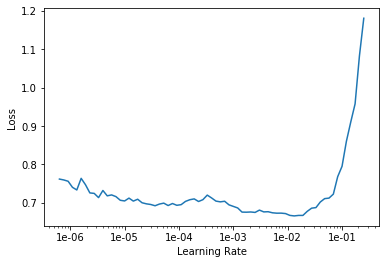

In [13]:
learn.lr_find()
learn.recorder.plot()

In [16]:
train(learn, 1e-2/2, 1e-5, 'b.p_mod_st2-')

epoch,train_loss,valid_loss,error_rate,kappa_score,time
0,0.628621,0.497260,0.189891,0.867343,07:18
1,0.602457,0.571643,0.228142,0.869694,07:13
2,0.571907,0.573001,0.237705,0.855178,07:37
3,0.542737,0.427070,0.159836,0.898478,07:25
4,0.493522,0.429396,0.168033,0.895308,07:34
5,0.464074,0.425827,0.161202,0.898428,07:27


epoch,train_loss,valid_loss,error_rate,kappa_score,time
0,0.471906,0.455030,0.181694,0.890604,07:21
1,0.467193,0.442685,0.165301,0.893129,07:14
2,0.438619,0.417844,0.150273,0.908174,07:05
3,0.390080,0.412055,0.154372,0.907887,07:04


### Model C

Here, we will again use Progressive resizing first from 128 to 256 and then finally to 512.

In [17]:
data = get_data(128, 84)
learn = get_learner(data, models.resnet34)

In [18]:
train(learn, 1e-2, 1e-5, 'c.p_mod-')

epoch,train_loss,valid_loss,error_rate,kappa_score,time
0,1.440816,1.043434,0.300546,0.700332,05:48
1,1.174089,0.987656,0.284153,0.732725,05:49
2,1.000550,0.737247,0.274590,0.737948,05:49
3,0.870223,0.681513,0.241803,0.760783,05:52
4,0.772368,0.662791,0.254098,0.782340,05:51
5,0.712293,0.647028,0.248634,0.788285,05:39


epoch,train_loss,valid_loss,error_rate,kappa_score,time
0,0.623771,0.670070,0.252732,0.802522,05:45
1,0.615179,0.673258,0.232240,0.822077,05:38
2,0.575777,0.627433,0.226776,0.844992,05:47
3,0.545543,0.603574,0.218579,0.849864,05:50


Now, converting images to 256.

In [11]:
data = get_data(256, 64)
learn = get_learner(data, models.resnet34)

In [12]:
learn.load('c.p_mod-2')

Learner(data=ImageDataBunch;

Train: LabelList (2930 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
2,4,1,0,0
Path: data;

Valid: LabelList (732 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
0,0,2,0,2
Path: data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
  

Checking lr_find() to see what should be the new learning rates for training.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


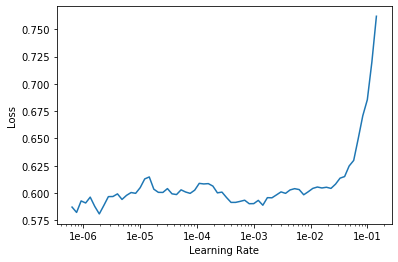

In [13]:
learn.lr_find()
learn.recorder.plot()

In [14]:
train(learn, 1e-2/2, 1e-5, 'c.p_mod_st2-')

epoch,train_loss,valid_loss,error_rate,kappa_score,time
0,0.559334,0.522270,0.198087,0.869756,06:08
1,0.582679,0.536705,0.195355,0.885968,06:05
2,0.567668,0.555680,0.215847,0.879583,06:04
3,0.552638,0.514110,0.181694,0.887282,05:51
4,0.526777,0.509084,0.180328,0.897458,06:04
5,0.499820,0.507493,0.180328,0.891992,06:02


epoch,train_loss,valid_loss,error_rate,kappa_score,time
0,0.475368,0.523575,0.187158,0.879232,06:11
1,0.476459,0.495288,0.183060,0.892329,06:03
2,0.465869,0.474735,0.177596,0.906992,06:00
3,0.440356,0.476679,0.174863,0.904787,06:04


Now, finally converting images to 512.

In [15]:
data = get_data(512, 48)
learn = get_learner(data, models.resnet34)

In [16]:
learn.load('c.p_mod_st2-2')

Learner(data=ImageDataBunch;

Train: LabelList (2930 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
2,4,1,0,0
Path: data;

Valid: LabelList (732 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
0,0,2,0,2
Path: data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
  

Checking lr_find() to see what should be the new learning rates for training.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


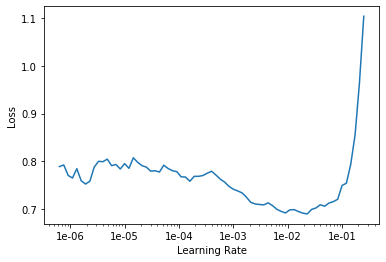

In [17]:
learn.lr_find()
learn.recorder.plot()

In [18]:
train(learn, 1e-2/3, 1e-5, 'c.p_mod_st3-')

epoch,train_loss,valid_loss,error_rate,kappa_score,time
0,0.601799,0.536738,0.198087,0.854140,07:00
1,0.552852,0.524403,0.193989,0.883070,07:09
2,0.539296,0.508099,0.184426,0.880867,07:11
3,0.499161,0.479636,0.178962,0.894058,06:55
4,0.472353,0.473064,0.183060,0.892880,07:04
5,0.442379,0.469308,0.181694,0.896353,07:33


epoch,train_loss,valid_loss,error_rate,kappa_score,time
0,0.440682,0.482173,0.180328,0.886378,07:29
1,0.436412,0.463845,0.170765,0.890023,07:12
2,0.401211,0.448445,0.169399,0.907014,07:04
3,0.370912,0.447898,0.165301,0.908004,07:05


### Exporting models

Exporting the models.

In [19]:
data = get_data(512, 48)
learn = get_learner(data, models.resnet34)

In [20]:
learn.load('c.p_mod_st3-2')
learn.export('model_c.pkl')

In [21]:
learn.load('b.p_mod_st2-2')
learn.export('model_b.pkl')

In [22]:
learn.load('a.p_mod-2')
learn.export('model_a.pkl')

### Inference

Here we are performing inference on the test set and creating a csv file so that it can be submitted to the competition.

Create test set.

In [24]:
test = ImageList.from_folder(path_test)

Load learner

In [25]:
path_learn = path + 'p_models/production/'

In [26]:
learn = load_learner(path_learn, file='model_c.pkl', test=test).to_fp16()

Perform Inference

In [27]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)
ans = torch.argmax(preds, dim=1)
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

Convert the answers to a csv file which can be used for submission to kaggle.

In [29]:
df = pd.DataFrame({'id_code': fnames, 'diagnosis': ans}, columns=['id_code', 'diagnosis'])

In [30]:
df.to_csv(path + 'submission.csv', index=False)